In [1]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import gdown
import os
from tqdm import tqdm

C:\Users\anuar\anaconda3\envs\dl\Lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# Set configuration and select device

# Training hyperparameters
BATCH_SIZE    = 64      # batch size
LR            = 1e-3     # learning rate
EPOCHS        = 60       # number of training epochs

# Dataset info
PAST_STEPS = 8           # number of past steps used as input
FUTURE_STEPS = 12        # number of future steps to predict
INPUT_DIM = 2       # (x, y)
OUTPUT_DIM = 2      # (x, y)

# Hyperparameters for the GRU
HIDDEN_SIZE = 64
NUM_LAYERS = 1

# Device selection: cuda if GPU is available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Download the preprocessed `.npz` dataset from Google Drive

NPZ_FILE_ID   = "1QJ8AbZyy1_h_UkRDLSPL_oFmsX8aimcU" 
OUT_NPZ_PATH  = "evac_P8F12_P5features_100runs.npz"

if not os.path.exists(OUT_NPZ_PATH):
    url = f"https://drive.google.com/uc?id={NPZ_FILE_ID}"
    print("⬇️ Downloading dataset from:", url)
    gdown.download(url, OUT_NPZ_PATH, quiet=False)
else:
    print("📂 Dataset already exists at:", OUT_NPZ_PATH)

print("✅ Dataset ready at:", OUT_NPZ_PATH)

📂 Dataset already exists at: evac_P8F12_P5features_100runs.npz
✅ Dataset ready at: evac_P8F12_P5features_100runs.npz


In [5]:
# Load and inspect the `.npz` dataset

data = np.load(OUT_NPZ_PATH, allow_pickle=True)

X_train = data["X_train"]  # shape: (N_train, 8, 5)
Y_train = data["Y_train"]  # shape: (N_train, 24)
X_test  = data["X_test"]   # shape: (N_test, 8, 5)
Y_test  = data["Y_test"]   # shape: (N_test, 24)

# Slice to keep only X and Y features
X_train = X_train[:, :, :2]  # shape: (N_train, 8, 2)
X_test  = X_test[:, :, :2]    # shape: (N_test, 8, 2)

feature_cols = data["feature_cols"]
past_steps   = int(data["past_steps"])
future_steps = int(data["future_steps"])

print("✅ Loaded dataset")
print("feature_cols:", feature_cols)
print("past_steps:", past_steps, "(expected 8)")
print("future_steps:", future_steps, "(expected 12)")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:",  X_test.shape)
print("Y_test shape:",  Y_test.shape)

# Optional check that shapes match our config
assert past_steps == PAST_STEPS, "past_steps mismatch!"
assert future_steps == FUTURE_STEPS, "future_steps mismatch!"
assert X_train.shape[2] == INPUT_DIM, "Input feature dimension mismatch!"
assert Y_train.shape[1] == FUTURE_STEPS*OUTPUT_DIM, "Output dimension mismatch!"

✅ Loaded dataset
feature_cols: ['xcor' 'ycor' 'vx' 'vy' 'emotion_val']
past_steps: 8 (expected 8)
future_steps: 12 (expected 12)
X_train shape: (3939492, 8, 2)
Y_train shape: (3939492, 24)
X_test shape: (984874, 8, 2)
Y_test shape: (984874, 24)


In [6]:
# Split training data into train and validation sets

from sklearn.model_selection import train_test_split

X_tr, X_val, Y_tr, Y_val = train_test_split(
    X_train,
    Y_train,
    test_size=0.2,      # 20% for validation out of 80% train data
    random_state=42,
    shuffle=True
)

print("Train set shape :", X_tr.shape, Y_tr.shape)     # 64% for train
print("Valid set shape :", X_val.shape, Y_val.shape)   # 16% for validation
print("Test  set shape :", X_test.shape, Y_test.shape) # 20% for test

Train set shape : (3151593, 8, 2) (3151593, 24)
Valid set shape : (787899, 8, 2) (787899, 24)
Test  set shape : (984874, 8, 2) (984874, 24)


In [7]:
# Create Torch Datasets and DataLoaders (train/val/test)

class TrajectoryDataset(Dataset):
    """
    Simple dataset for trajectory prediction.
    Each item returns:
      - input sequence: shape (past_steps, input_dim)
      - target vector: shape (future_steps, output_dim)
    """
    def __init__(self, X, Y):
        super().__init__()
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (past_steps, input_dim)
        y = self.Y[idx]  # (future_steps, output_dim)
        return x, y


# Create datasets for train, validation, and test splits
train_dataset = TrajectoryDataset(X_tr, Y_tr)
val_dataset   = TrajectoryDataset(X_val, Y_val)
test_dataset  = TrajectoryDataset(X_test, Y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("✅ DataLoaders created")
print("Train batches:", len(train_loader))
print("Val batches:  ", len(val_loader))
print("Test batches: ", len(test_loader))

✅ DataLoaders created
Train batches: 49244
Val batches:   12311
Test batches:  15389


In [8]:
# Define GRU model

class GRUTrajectoryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, future_steps, output_features):
        super().__init__()
        # 1) Recurrent layer: GRU processes the input sequence
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # input/output as (batch, seq, features)
        )

        # 2) Output layer: maps final hidden state to all future positions
        self.fc = nn.Linear(hidden_size, future_steps * output_features)

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_size)
        Returns:
            future_flat: (batch_size, future_steps * output_features)
        """
        # 1) Pass through GRU
        out, h_n = self.gru(x)        # out: (batch, seq_len, hidden_size)
                                      # h_n: (num_layers, batch, hidden_size)

        # 2) Take last layer's hidden state
        last_hidden = h_n[-1]         # (batch, hidden_size)

        # 3) Map to flattened future trajectory
        future_flat = self.fc(last_hidden)  # e.g. (batch, 24)
        return future_flat


# Create the model instance and move it to the selected device
model = GRUTrajectoryPredictor(
    input_size=INPUT_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    future_steps=FUTURE_STEPS,
    output_features=OUTPUT_DIM
).to(device)

print(model)

GRUTrajectoryPredictor(
  (gru): GRU(2, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=24, bias=True)
)


In [9]:
# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)  

# Save best model weights after improvements
best_val_loss = float('inf')
save_path = "best_gru_model.pth"

In [10]:
# Define Training and Evaluation Function

def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    One epoch of training over the training DataLoader.
    Performs:
      - forward pass
      - backward pass
      - gradient clipping
      - optimizer step
    Returns:
      - average MSE loss
    """
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X_batch, Y_batch in loader:
        # Move data to device
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        Y_pred = model(X_batch)

        # Compute loss
        loss = criterion(Y_pred, Y_batch)

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Logging
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / max(1, num_batches)
    return avg_loss


def evaluate(model, loader, criterion, device):
    """
    Simple fast evaluation for MSE during training.
    """
    model.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / max(1, num_batches)
    return avg_loss


def evaluate_with_metrics(model, loader, criterion, device, future_steps):
    """
    Full evaluation for:
      - MSE 
      - ADE (Average Displacement Error)
      - FDE (Final Displacement Error)
    """
    model.eval()
    total_loss = 0.0
    total_ade  = 0.0
    total_fde  = 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)

            # MSE
            loss = criterion(Y_pred, Y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size

            # ADE / FDE
            B = batch_size
            pred_xy = Y_pred.view(B, future_steps, 2)  # (B, future_steps, 2)
            true_xy = Y_batch.view(B, future_steps, 2) # (B, future_steps, 2)

            dists = torch.norm(pred_xy - true_xy, dim=2)  # (B, future_steps)

            ade_batch = dists.mean(dim=1)   # (B,)
            fde_batch = dists[:, -1]        # (B,)

            total_ade += ade_batch.sum().item()
            total_fde += fde_batch.sum().item()
            total_samples += batch_size

    mse = total_loss / max(1, total_samples)
    ade = total_ade  / max(1, total_samples)
    fde = total_fde  / max(1, total_samples)

    return mse, ade, fde


In [11]:
# Train the model

train_losses = []   # per-epoch train MSE
val_losses   = []   # per-epoch validation MSE
train_times  = []   # per-epoch train time (seconds)
val_times    = []   # per-epoch val time (seconds)

for epoch in tqdm(range(1, EPOCHS + 1)):
    # ---- Train on training set ----
    t0 = time.time()
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device
    )
    t1 = time.time()
    epoch_train_time = t1 - t0
    train_times.append(epoch_train_time)

    # ---- Evaluate on validation set ----
    t2 = time.time()
    val_loss = evaluate(
        model,
        val_loader,
        criterion,
        device
    )
    t3 = time.time()
    epoch_val_time = t3 - t2
    val_times.append(epoch_val_time)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    # # Print details after each epoch
    # # Uncommented to make tqdm time bar better, but can be uncommented if you want
    # print(
    #     f"Epoch {epoch:02d}/{EPOCHS} | "
    #     f"Train MSE: {train_loss:.6f} | "
    #     f"Val MSE: {val_loss:.6f}  | "
    #     f"Train time: {epoch_train_time:.2f}s | Val time: {epoch_val_time:.2f}s"
    # )

print("✅ Training complete. Best Val MSE:", best_val_loss,
      " Best Val RMSE:", np.sqrt(best_val_loss))
print("Mean Train time:", np.mean(train_times),
      " Mean Val time:", np.mean(val_times))

100%|██████████| 60/60 [3:12:18<00:00, 192.31s/it]  

✅ Training complete. Best Val MSE: 2.3347739838012274  Best Val RMSE: 1.5279967224445303
Mean Train time: 172.357463657856  Mean Val time: 19.95038126707077


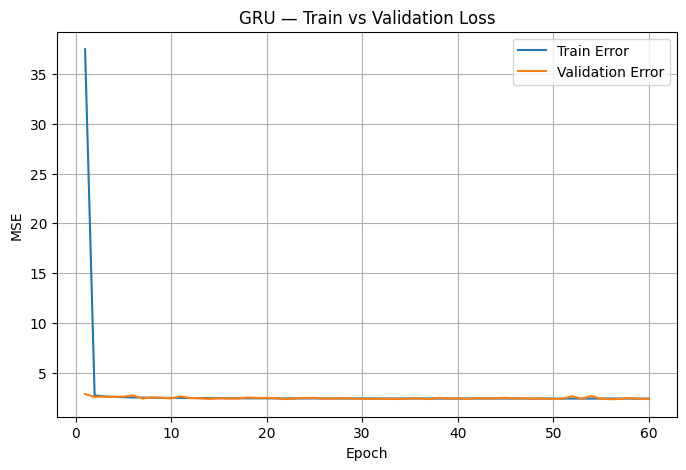

In [12]:
plt.figure(figsize=(8, 5))
epochs=range(1, EPOCHS + 1)
plt.plot(epochs, train_losses, label="Train Error")
plt.plot(epochs, val_losses, label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("GRU — Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Evaluate final model
model.load_state_dict(torch.load(save_path))
model.eval()

test_mse, test_ade, test_fde = evaluate_with_metrics(
    model,
    test_loader,
    criterion,
    device,
    future_steps=FUTURE_STEPS
)

test_rmse = np.sqrt(test_mse)

print("=====================================")
print("   FINAL TEST SET EVALUATION")
print("=====================================")
print(f"Test MSE : {test_mse:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"Test ADE : {test_ade:.6f}")
print(f"Test FDE : {test_fde:.6f}")
print("=====================================")

   FINAL TEST SET EVALUATION
Test MSE : 2.332181
Test RMSE: 1.527148
Test ADE : 1.775394
Test FDE : 2.574479


In [14]:
# Measure inference latency on the test set
model.eval()
start_time = time.time()

num_samples = 0
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        # Only forward pass (no loss, no backward)
        _ = model(X_batch)
        num_samples += X_batch.size(0)

end_time = time.time()
total_inference_time = end_time - start_time

avg_time_per_sample = total_inference_time / max(1, num_samples)

print("=========== Inference Latency ===========")
print(f"Total inference time on test set: {total_inference_time:.4f} s")
print(f"Number of samples              : {num_samples}")
print(f"Average time per sample        : {avg_time_per_sample*1000:.4f} ms")
print("=========================================")

=========== Inference Latency ===========
Total inference time on test set: 23.7193 s
Number of samples              : 984874
Average time per sample        : 0.0241 ms


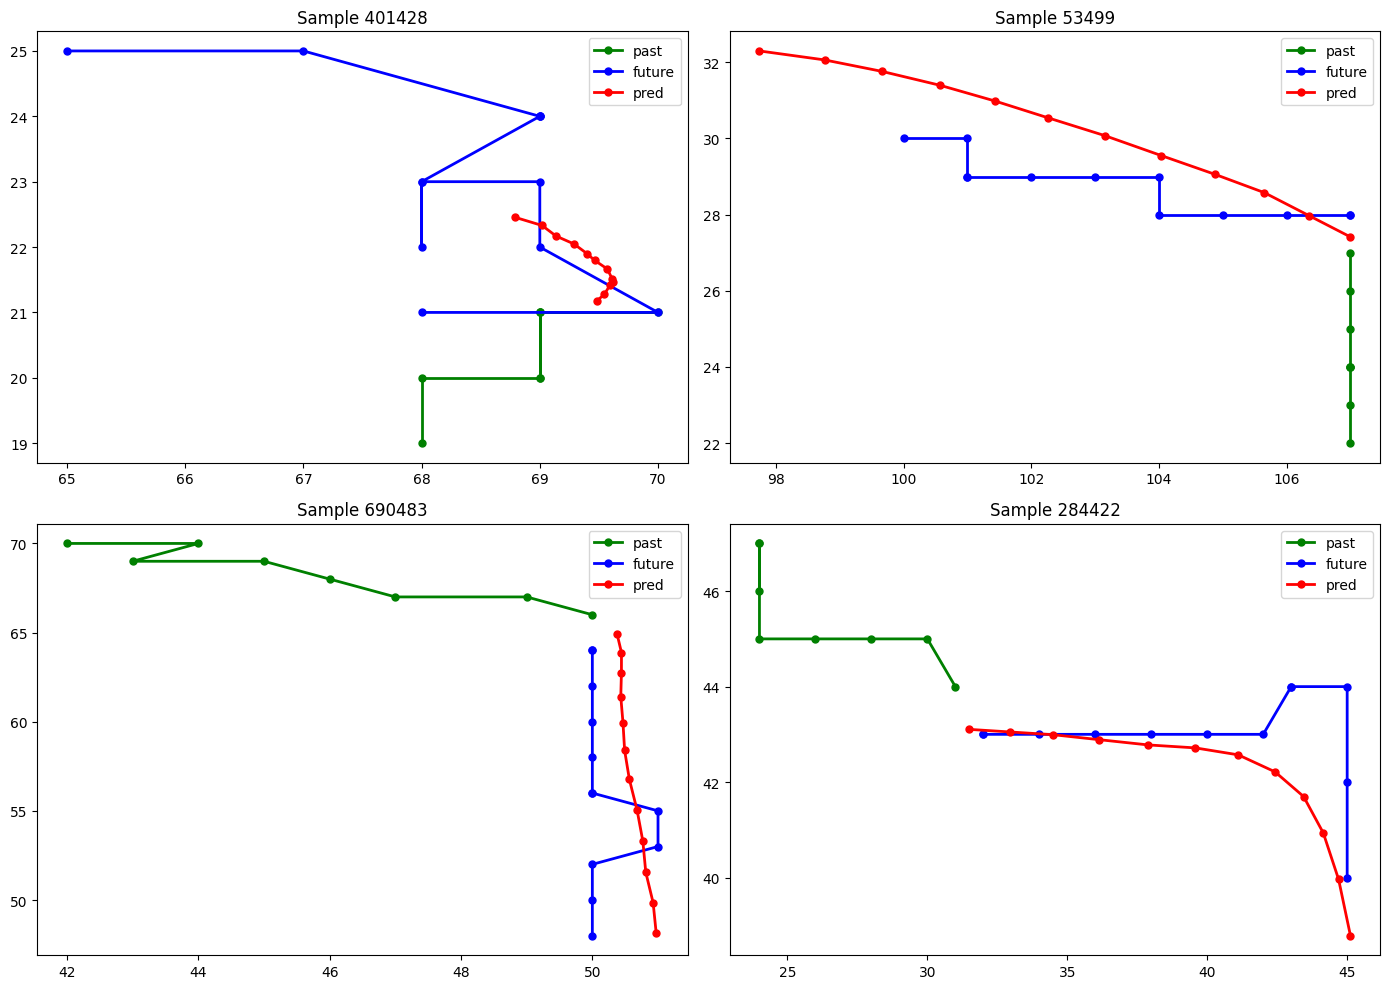

In [15]:
# Visualize trajectories by index

# Exact indices you want to plot
selected_indices = [401428, 53499, 690483, 284422]

rows = 2
cols = 2

plt.figure(figsize=(14, 10))

model.eval()

for i, idx in enumerate(selected_indices):
    X_sample = X_test[idx]
    Y_true   = Y_test[idx].reshape(FUTURE_STEPS, 2)

    with torch.no_grad():
        X_tensor = torch.tensor(X_sample, dtype=torch.float32).unsqueeze(0).to(device)
        Y_pred   = model(X_tensor).cpu().numpy().reshape(FUTURE_STEPS, 2)

    past = X_sample[:, :2]

    ax = plt.subplot(rows, cols, i + 1)

    # Past (green)
    ax.plot(
        past[:, 0], past[:, 1],
        'o-', color='green', markersize=5, linewidth=2,
        label='past'
    )

    # True future (blue)
    ax.plot(
        Y_true[:, 0], Y_true[:, 1],
        'o-', color='blue', markersize=5, linewidth=2,
        label='future'
    )

    # Predicted (red)
    ax.plot(
        Y_pred[:, 0], Y_pred[:, 1],
        'o-', color='red', markersize=5, linewidth=2,
        label='pred'
    )

    ax.set_title(f"Sample {idx}", fontsize=12)

    ax.legend()

    ax.grid(False)

plt.tight_layout()
plt.show()

In [16]:
# Measure peak GPU memory usage during inference

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)

    model.eval()
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            _ = model(X_batch)  # forward pass only

    peak_mem_bytes = torch.cuda.max_memory_allocated(device)
    peak_mem_mb = peak_mem_bytes / (1024 ** 2)

    print("=========== GPU Memory Usage ===========")
    print(f"Peak GPU memory allocated during inference: {peak_mem_mb:.2f} MB")
    print("========================================")
else:
    print("CUDA GPU is not available — cannot measure GPU memory usage.")

=========== GPU Memory Usage ===========
Peak GPU memory allocated during inference: 26.76 MB


In [17]:
# Measure GPU power usage during inference using NVML
# Only works on local NVIDIA GPUs (not Colab)

import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # GPU 0

power_samples = []
timestamps    = []

model.eval()
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)

        # Measure power before forward pass
        power_watts = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000.0  # convert mW → W
        power_samples.append(power_watts)
        timestamps.append(time.time())

        _ = model(X_batch)  # inference step

# Compute energy (approx)
energy_joules = 0
for i in range(1, len(timestamps)):
    dt = timestamps[i] - timestamps[i - 1]
    energy_joules += power_samples[i] * dt

print("=========== REAL GPU POWER ANALYSIS ===========")
print(f"Average GPU Power      : {sum(power_samples)/len(power_samples):.2f} W")
print(f"Peak GPU Power         : {max(power_samples):.2f} W")
print(f"Estimated Energy Usage : {energy_joules:.2f} Joules")
print("===============================================")


=========== REAL GPU POWER ANALYSIS ===========
Average GPU Power      : 9.70 W
Peak GPU Power         : 11.00 W
Estimated Energy Usage : 235.99 Joules


In [18]:
# Measure number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("=========== Parameter Analysis ===========")
print(f"Number of parameters   : {count_parameters(model)}")
print("==========================================")

=========== Parameter Analysis ===========
Number of parameters   : 14616
